In [28]:
import os, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from beamconv import tools, ScanStrategy, Beam
import qpoint as qp

In [29]:
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
lmax=700 
ell, cls = cls[0], cls[1:]
np.random.seed(25) 
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK

In [30]:
fwhm = 40

beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian')

spin_opts = dict(max_spin=2,      # Symmetric beams, so 2 is sufficient
                 nside_spin=256)  # nside of scanned maps 

scan_opts = dict(ra0=[-10],       # Center of scan
                 dec0=[-57.5],
                 az_throw=20,     # Scan width
                 scan_speed=1,
                 verbose=0)

mlen        = 1000        # Mission length in seconds
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60

In [31]:
bideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
# Create a Gaussian beam (f.o.v. is 3 degrees)
bideal.create_focal_plane(nrow=1, ncol=1, fov=3, no_pairs=True,**beam_opts)
# Calculate tods in two chunks
chunks = bideal.partition_mission(0.5*bideal.mlen*bideal.fsamp) 
# Allocate and assign parameters for mapmaking
bideal.allocate_maps(nside=256)
# Set instrument rotation
bideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
# Set elevation stepping
bideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
# Set HWP modulation
bideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'
#scan
bideal.scan_instrument_mpi(alm, hwp_status='ideal', **scan_opts)

In [39]:
hwp_models = ('HWP_only', 'Ar+HWP+Ar', 'Ar1+Ar2+HWP+Ar2+Ar1', 'SPIDER_95', 'SPIDER_150')
freqs = np.arange(80e9, 180e9, 1e9)
diff_mean = np.zeros((5,freqs.size))
diff_std = np.zeros((5,freqs.size))
start_time = time.time()
for i, hwp_model in enumerate(hwp_models):
    print(time.time()-start_time)
    print('Working on model', hwp_model)
    hwp = Beam().hwp()
    hwp.choose_HWP_model(hwp_model)
    for j, freq in enumerate(freqs):
        bnideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
        beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian', hwp=hwp, sensitive_freq=freq)
        # Calculate tods in two chunks
        bnchunks = bnideal.partition_mission(0.5*bnideal.mlen*bnideal.fsamp) 
        # Allocate and assign parameters for mapmaking
        bnideal.allocate_maps(nside=256)
        # Set instrument rotation
        bnideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
        # Set elevation stepping
        bnideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
        # Set HWP modulation
        bnideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'
        bnideal.create_focal_plane(nrow=1, ncol=1, fov=3, no_pairs=True,**beam_opts)
        # Scan
        bnideal.scan_instrument_mpi(alm, hwp_status='non-ideal', **scan_opts)
        #Store resulting average difference and standard deviation
        diff_mean[i,j] = np.mean(bnideal.tod-bideal.tod)
        diff_std[i,j] = np.std(bnideal.tod-bideal.tod)


0.0005400180816650391
Working on model HWP_only
202.64446878433228
Working on model Ar+HWP+Ar
384.94037795066833
Working on model Ar1+Ar2+HWP+Ar2+Ar1
584.7175269126892
Working on model SPIDER_95
789.3469409942627
Working on model SPIDER_150


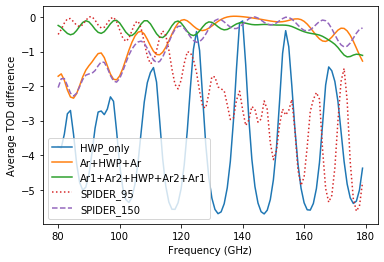

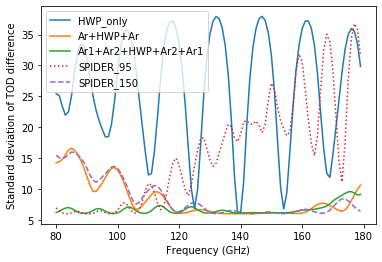

In [44]:
plt.plot(freqs/1e9,diff_mean[0,:])
plt.plot(freqs/1e9,diff_mean[1,:])
plt.plot(freqs/1e9,diff_mean[2,:])
plt.plot(freqs/1e9,diff_mean[3,:],':')
plt.plot(freqs/1e9,diff_mean[4,:],'--')
plt.legend(hwp_models)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Average TOD difference')
plt.figure(2)
plt.plot(freqs/1e9,diff_std[0,:])
plt.plot(freqs/1e9,diff_std[1,:])
plt.plot(freqs/1e9,diff_std[2,:])
plt.plot(freqs/1e9,diff_std[3,:],':')
plt.plot(freqs/1e9,diff_std[4,:],'--')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Standard deviation of TOD difference')
plt.legend(hwp_models)